In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import silhouette_score
from tqdm import tqdm
# --- Configuration ---
# 1. Prediction Input: Window Size (number of frames to aggregate)
WINDOW_SIZE = 60  # e.g., 30 frames ~ 1 second (depending on FPS)

print("Configuration set.")


Configuration set.


***Training***

Step #1 read data

In [3]:
data_path = '../../output/training_data/game1_set1_tracks.csv'
df = pd.read_csv(data_path)
labels_path = "../../output/training_data/game1_rally_labels_per_frame.csv"
labels = pd.read_csv(labels_path)

In [4]:
df.head()

,frame,class,conf,x1,y1,x2,y2,cx,cy,track_id,vx,vy,speed_px_frame,direction_deg
0,0,0,0.3540,1222,487,1240,507,1231.0,497.0,0,0.0,0.0,0.0,0.0
1,1,0,0.3313,1222,487,1240,507,1231.0,497.0,0,0.0,0.0,0.0,0.0
2,2,0,0.3337,1222,487,1240,505,1231.0,496.0,0,0.0,-1.0,1.0,0.0
3,3,0,0.3296,1222,487,1240,505,1231.0,496.0,0,0.0,0.0,0.0,0.0
4,4,0,0.2043,1222,487,1240,505,1231.0,496.0,0,0.0,0.0,0.0,0.0


Step 2 clean data

In [9]:
def clean_noise(dfo):
    """
    Filters noisy tracking data and resolves temporal overlaps to produce a clean single-object trajectory.

    The function performs a four-stage cleaning process:
    1. Statistics Calculation: Aggregates track duration, confidence, and Euclidean displacement.
    2. Hard Filtering: Removes tracks that are static (displacement < 20px), very short 
       (flickers), or consistently low confidence.
    3. Overlap Resolution: For frames with multiple valid detections, selects the track 
       with the highest 'quality_score' (Duration * Confidence * Displacement).
    4. Post-Processing: Removes fragmented tracks that fall below a minimum length 
       threshold after deduplication.

    Args:
        tracking_csv (str): Path to the input CSV file containing raw tracking data. 
            Expected columns: ['track_id', 'frame', 'conf', 'cx', 'cy'].
        output_csv (str): Path where the cleaned CSV will be saved.

    Returns:
        None: Saves the resulting DataFrame to output_csv.
    """
    df = dfo.copy()
    
    # 1. Calculate Statistics with Vectorized Physics
    stats = df.groupby('track_id').agg(
        duration=('frame', 'count'),
        start_f=('frame', 'min'),
        end_f=('frame', 'max'),
        m_conf=('conf', 'mean'),
        max_conf=('conf', 'max'),
        dist_x=('cx', lambda x: x.max() - x.min()),
        dist_y=('cy', lambda x: x.max() - x.min())
    )

    # Calculate Euclidean displacement
    stats['displacement'] = np.sqrt(stats['dist_x']**2 + stats['dist_y']**2)
    
    # Quality Score: Rewards movement and duration
    stats['quality_score'] = stats['duration'] * stats['m_conf'] * (stats['displacement'] + 1)

    # 2. Hard Noise Filtering
    is_noise = (
        (stats['displacement'] < 500) | # Static objects
        (stats['duration'] < 20) |      # Flickers
        ((stats['duration'] < 30) & (stats['max_conf'] < 0.6)) | # Short low-confidence tracks
        (stats['m_conf'] < 0.35) # Overall low-confidence tracks
    )
    valid_ids = stats[~is_noise].index 
    df = df[df['track_id'].isin(valid_ids)].copy() 

    # 3. Resolve Overlaps by Quality Score
    df = df.merge(stats[['quality_score']], on='track_id', how='left')
    df = df.sort_values(by=['frame', 'quality_score'], ascending=[True, False])
    
    # Keep only the best detection per frame
    df_cleaned = df.drop_duplicates(subset=['frame'], keep='first')

    # 4. Post-Process: Remove fragmented tracks left over after deduplication
    final_counts = df_cleaned['track_id'].value_counts()
    valid_final_tracks = final_counts[final_counts >= 5].index
    df_cleaned = df_cleaned[df_cleaned['track_id'].isin(valid_final_tracks)]

    # Final Sort
    df_cleaned = df_cleaned.sort_values('frame').drop(columns=['quality_score'])
    
    return df_cleaned

In [10]:
clean_df= clean_noise(df)

In [11]:
clean_df.head()

,frame,class,conf,x1,y1,x2,y2,cx,cy,track_id,vx,vy,speed_px_frame,direction_deg
0,65,0,0.3015,608,0,637,20,622.5,10.0,2,0.0,0.0,0.000000,0.0
1,66,0,0.6943,633,0,673,28,653.0,14.0,2,30.5,4.0,30.761177,0.0
2,67,0,0.8101,656,0,702,43,679.0,21.5,2,26.0,7.5,27.060118,0.0
3,68,0,0.8291,682,11,726,50,704.0,30.5,2,25.0,9.0,26.570661,0.0
4,69,0,0.8716,708,25,750,63,729.0,44.0,2,25.0,13.5,28.412145,0.0


Visaul Test of cleaning

In [444]:
def visualize_ball_tracking(video_path, cleaned_df, output_path="output_viz.mp4", limit=1000, start_frame=0):
    """
    Overlays tracking results on video starting from a specific frame.
    :param limit: Maximum number of frames to process from the start_frame.
    :param start_frame: The index of the frame where visualization begins.
    """
    cap = cv2.VideoCapture(video_path)
    
    # 1. Set the starting frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # 2. Adjust frame range logic
    # The actual end frame is start_frame + limit, but cannot exceed total_frames
    end_frame = total_frames if limit is None else min(start_frame + limit, total_frames)
    frames_to_process = end_frame - start_frame

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Convert DF to dictionary for O(1) lookup
    ball_lookup = cleaned_df.set_index('frame').to_dict('index')
    
    trail = []

    # Progress bar should reflect the number of frames we are actually processing
    pbar = tqdm(total=frames_to_process, desc="Writing Video")

    while cap.isOpened():
        frame_idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        
        # 3. Check if we have reached the end of our requested range
        if frame_idx >= end_frame:
            break

        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx in ball_lookup:
            data = ball_lookup[frame_idx]
            data['x']= (data['x1']+data['x2'])/2
            data['y']= (data['y1']+data['y2'])/2
            center = (int(data['x']), int(data['y']))
            trail.append(center)
            
            # Draw Bounding Box
            cv2.rectangle(frame, (int(data['x1']), int(data['y1'])), 
                          (int(data['x2']), int(data['y2'])), (0, 255, 0), 2)
            
            # Draw Confidence
            cv2.putText(frame, f"Conf: {data['conf']:.2f}", (int(data['x1']), int(data['y1'])-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Draw the trajectory trail
        if len(trail) > 1:
            for i in range(1, len(trail)):
                d = np.sqrt((trail[i][0]-trail[i-1][0])**2 + (trail[i][1]-trail[i-1][1])**2)
                if d < 400: 
                    cv2.line(frame, trail[i-1], trail[i], (255, 255, 0), 2)
        
        if len(trail) > 30:
            trail.pop(0)

        out.write(frame)
        pbar.update(1)

    pbar.close()
    cap.release()
    out.release()
    print(f"Visualization saved to {output_path} (Frames {start_frame} to {end_frame})")

In [445]:
visualize_ball_tracking(r"../videos/game1_set1.mp4", cleaned_df=clean_df, start_frame=2000, limit=1000)

Writing Video: 100%|██████████| 1000/1000 [00:16<00:00, 61.56it/s]

Visualization saved to output_viz.mp4 (Frames 2000 to 3000)


In [12]:
clean_df.head()

,frame,class,conf,x1,y1,x2,y2,cx,cy,track_id,vx,vy,speed_px_frame,direction_deg
0,65,0,0.3015,608,0,637,20,622.5,10.0,2,0.0,0.0,0.000000,0.0
1,66,0,0.6943,633,0,673,28,653.0,14.0,2,30.5,4.0,30.761177,0.0
2,67,0,0.8101,656,0,702,43,679.0,21.5,2,26.0,7.5,27.060118,0.0
3,68,0,0.8291,682,11,726,50,704.0,30.5,2,25.0,9.0,26.570661,0.0
4,69,0,0.8716,708,25,750,63,729.0,44.0,2,25.0,13.5,28.412145,0.0


In [13]:
def interpolate_small_gaps(series, max_gap):
    # Find groups of NaNs
    isnull = series.isnull()
    # Create a unique ID for each contiguous block of NaNs
    gap_ids = (isnull != isnull.shift()).cumsum()
    # Count the size of each gap
    gap_sizes = gap_ids.map(gap_ids[isnull].value_counts())
    
    # Only interpolate where the gap size is <= our limit
    return series.interpolate(method='linear').where(gap_sizes <= max_gap, series)

In [16]:
def extract_features(dfo, window_size=60, start_frame=0, interpolation_size=5):
    """
    Transforms raw tracking coordinates into physics-based features for rally classification.

    The function creates a fixed-frequency timeline, fills small tracking gaps, 
    calculates instantaneous kinematics (velocity, acceleration, angles), and 
    generates rolling window statistics to provide temporal context.

    Args:
        input_csv (str): Path to the cleaned tracking CSV.
        output_csv (str): Path to save the engineered features CSV.
        window_size (int): Size of the rolling window in frames (60 frames = ~2 sec).
        start_frame (int): The frame index to start the timeline from.
        interpolation_size (int): Max consecutive frames to fill via linear interpolation.

    Returns:
        None: Saves the feature-rich DataFrame to output_csv.
    """
    df = dfo.copy()
    
    # 1. TIMELINE EXPANSION
    # Ensure every frame exists in the DataFrame, even if no detection occurred.
    # This is critical for accurate velocity (pixels per frame) math.
    df = df.sort_values('frame')
    full_range = pd.DataFrame({'frame': range(start_frame, int(df['frame'].max()) + 1)})
    df = pd.merge(full_range, df, on='frame', how='left')
    
    # Fill tiny gaps (flickers) while keeping long disappearances empty
    df['cx'] = interpolate_small_gaps(df['cx'], max_gap=interpolation_size)
    df['cy'] = interpolate_small_gaps(df['cy'], max_gap=interpolation_size)
    df['conf'] = df['conf'].fillna(0)
    
    # 2. BASIC PHYSICS (Vectorized)
    # Velocity is the first derivative of position
    df['vx'] = df['cx'].diff().fillna(0)
    df['vy'] = df['cy'].diff().fillna(0)
    df['velocity'] = np.sqrt(df['vx']**2 + df['vy']**2)
    
    # Noise Reduction: Clip unrealistic jumps caused by ID-switching or tracking errors
    df['velocity'] = df['velocity'].clip(upper=300)
    
    # Acceleration is the first derivative of velocity
    df['acceleration'] = df['velocity'].diff().fillna(0)
    
    # Angular changes: Used to detect sharp changes in direction (sets, spikes, floor bounces)
    df['angle'] = np.degrees(np.arctan2(df['vy'], df['vx']))
    df['angle_diff'] = df['angle'].diff().abs() % 360
    # Ensure we get the shortest angular distance (e.g., 350 deg to 10 deg is 20, not 340)
    df['angle_diff'] = np.minimum(df['angle_diff'], 360 - df['angle_diff']).fillna(0)

    # 3. RALLY-SPECIFIC ENGINEERED FEATURES
    # y_dominance: Rallies involve high arcs (vertical). Downtime involves horizontal walking.
    df['y_dominance'] = np.abs(df['vy']) / (np.abs(df['vx']) + 1e-5)
    
    # accel_jitter: Detects "shaky" or erratic movement typical of manual handling or noise.
    df['accel_jitter'] = df['acceleration'].diff().abs().fillna(0)
    
    # energy: Squares velocity to emphasize high-speed spikes/serves.
    df['energy'] = df['velocity']**2
    
    # is_low: Heuristic to detect if the ball is on the floor (usually downtime).
    if not df['cy'].dropna().empty:
        floor_threshold = df['cy'].quantile(0.7)
        df['is_low'] = (df['cy'] > floor_threshold).astype(int)
    else:
        df['is_low'] = 0

    # 4. ROLLING WINDOW FEATURES (The 'Context')
    # Using center=True allows the model to "see" a bit of the past and future 
    # when determining if the current frame is part of a rally.
    rolling = df.rolling(window=window_size, center=True, min_periods=1)
    
    df['mean_x'] = rolling['cx'].mean()
    df['mean_y'] = rolling['cy'].mean()
    df['std_x'] = rolling['cx'].std().fillna(0)
    df['std_y'] = rolling['cy'].std().fillna(0)
    df['mean_velocity'] = rolling['velocity'].mean()
    df['max_velocity'] = rolling['velocity'].max()
    df['std_velocity'] = rolling['velocity'].std().fillna(0)
    df['mean_acceleration'] = rolling['acceleration'].mean()
    df['mean_angle_change'] = rolling['angle_diff'].mean()
    df['mean_y_dominance'] = rolling['y_dominance'].mean()
    df['mean_accel_jitter'] = rolling['accel_jitter'].mean()
    df['mean_energy'] = rolling['energy'].mean()
    
    # y_range_window: Measures the vertical "spread." Rallies have huge ranges;
    # someone holding a ball has a very narrow vertical range.
    df['y_range_window'] = rolling['cy'].max() - rolling['cy'].min()
    
    # Visibility/Confidence consistency: Rallies often have lower/varied confidence
    # due to motion blur, unlike static downtime.
    df['mean_vis'] = rolling['conf'].mean()
    df['vis_std'] = rolling['conf'].std().fillna(0)
    df['is_low_window'] = rolling['is_low'].mean()
    
    return df

In [ ]:
import pandas as pd
import numpy as np

def extract_features(dfo, window_size=15, start_frame=0, interpolation_size=5):
    """
    Transforms raw tracking coordinates into physics-based features.
    Updated to provide TWO windows: 
    - 'prev_': Statistics of frames BEFORE the current frame.
    - 'next_': Statistics of frames AFTER the current frame.
    """
    df = dfo.copy()
    
    # 1. TIMELINE EXPANSION (Same as before)
    df = df.sort_values('frame')
    full_range = pd.DataFrame({'frame': range(start_frame, int(df['frame'].max()) + 1)})
    df = pd.merge(full_range, df, on='frame', how='left')
    
    # Fill tiny gaps
    df['cx'] = df['cx'].interpolate(limit=interpolation_size) # Placeholder for your interpolate function
    df['cy'] = df['cy'].interpolate(limit=interpolation_size)
    df['conf'] = df['conf'].fillna(0)
    
    # 2. BASIC PHYSICS (Vectorized)
    df['vx'] = df['cx'].diff().fillna(0)
    df['vy'] = df['cy'].diff().fillna(0)
    df['velocity'] = np.sqrt(df['vx']**2 + df['vy']**2).clip(upper=300)
    df['acceleration'] = df['velocity'].diff().fillna(0)
    df['energy'] = df['velocity']**2
    
    # 3. DEFINE ROLLING OBJECTS
    # 'Past' window: looks at window_size frames ending at current frame
    # We use closed='left' to ensure the CURRENT frame isn't included in the past stats
    past_rolling = df.rolling(window=window_size, min_periods=1, closed='left')
    
    # 'Future' window: We shift the dataframe backwards and then roll
    # This effectively looks at window_size frames starting AFTER the current frame
    future_rolling = df.shift(-window_size).rolling(window=window_size, min_periods=1)

    # 4. APPLY ROLLING STATS
    # List of features to calculate for both windows
    features_to_roll = ['cy', 'velocity', 'acceleration', 'energy', 'conf']
    
    for feat in features_to_roll:
        # Past features
        df[f'prev_mean_{feat}'] = past_rolling[feat].mean()
        df[f'prev_max_{feat}'] = past_rolling[feat].max()
        df[f'prev_std_{feat}'] = past_rolling[feat].std().fillna(0)
        
        # Future features
        df[f'next_mean_{feat}'] = future_rolling[feat].mean()
        df[f'next_max_{feat}'] = future_rolling[feat].max()
        df[f'next_std_{feat}'] = future_rolling[feat].std().fillna(0)

    # Specific feature: Y Range (very useful for volleyball)
    df['prev_y_range'] = past_rolling['cy'].max() - past_rolling['cy'].min()
    df['next_y_range'] = future_rolling['cy'].max() - future_rolling['cy'].min()

    # Clean up NaNs created by windows at the very start/end of the video
    df = df.fillna(0)
    
    return df

In [123]:
features_df = extract_features(clean_df,window_size=50)

In [42]:
features_df[100:200]

,frame,class,conf,x1,y1,x2,y2,cx,cy,track_id,vx,vy,speed_px_frame,direction_deg,velocity,acceleration,energy,prev_mean_cy,prev_std_cy,next_mean_cy,next_std_cy,prev_mean_velocity,prev_std_velocity,next_mean_velocity,next_std_velocity,prev_mean_acceleration,prev_std_acceleration,next_mean_acceleration,next_std_acceleration,prev_mean_energy,prev_std_energy,next_mean_energy,next_std_energy,prev_mean_conf,prev_std_conf,next_mean_conf,next_std_conf,prev_y_range,next_y_range
100,100,0.0,0.7593,991.0,366.0,1009.0,387.0,1000.0,376.5,2.0,-7.5,-18.5,19.962465,0.0,19.962465,0.000000,398.50,286.687500,129.798734,248.766667,42.503698,17.572711,10.756887,12.307330,4.097472,-0.281656,6.691077,-0.124583,3.723359,420.653776,288.860365,167.700000,127.862153,0.515050,0.365114,0.693073,0.212331,372.5,146.50
101,101,0.0,0.3267,981.0,343.0,999.0,361.0,990.0,352.0,2.0,-10.0,-24.5,26.462237,0.0,26.462237,6.499772,700.25,298.080357,122.745334,246.966667,38.978317,17.320249,10.602753,11.948334,3.184659,-0.252462,6.690305,-0.358996,3.507011,408.662109,281.741785,152.566667,80.900800,0.512870,0.363393,0.703603,0.201070,357.5,135.00
102,102,0.0,0.1128,974.0,330.0,996.0,351.0,985.0,340.5,2.0,-5.0,-11.5,12.539936,0.0,12.539936,-13.922301,157.25,308.062500,114.830645,246.050000,36.974677,17.395409,10.661089,12.105034,3.327237,0.075160,6.774581,0.156700,2.409550,412.470443,284.975150,157.233333,85.108702,0.495943,0.359703,0.727123,0.168152,341.5,120.50
103,103,0.0,0.7397,965.0,314.0,987.0,338.0,976.0,326.0,2.0,-9.0,-14.5,17.066048,0.0,17.066048,4.526112,291.25,317.062500,106.562550,246.166667,37.240211,16.933382,10.557202,12.140318,3.386741,-0.462027,7.224811,0.035284,2.269486,394.478776,283.426305,158.475000,87.372921,0.472800,0.361325,0.729550,0.168863,324.0,124.00
104,104,0.0,0.7876,957.0,298.0,979.0,322.0,968.0,310.0,2.0,-8.0,-16.0,17.888544,0.0,17.888544,0.822496,320.00,324.919643,98.206982,247.333333,39.771185,16.591054,10.373160,12.118006,3.349566,-0.342328,7.278306,-0.022312,2.270744,379.278776,275.984825,157.691667,85.968912,0.471057,0.359855,0.718237,0.176056,304.5,139.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,0.0,0.8232,400.0,267.0,446.0,311.0,423.0,289.0,2.0,-25.0,13.0,28.178006,0.0,28.178006,3.944764,794.00,257.416667,53.527963,614.656667,217.714987,15.762773,4.272203,28.157547,35.624671,0.607081,1.944171,-0.939267,17.114445,266.108333,129.804191,2019.660750,3745.983567,0.802093,0.073854,0.225567,0.335640,196.0,540.95
196,196,0.0,0.8184,373.0,284.0,422.0,330.0,397.5,307.0,2.0,-25.5,18.0,31.212978,0.0,31.212978,3.034972,974.25,262.083333,49.717145,636.632143,207.954117,16.501346,4.441835,27.117114,35.986317,0.738574,2.033064,-1.040433,17.099105,291.366667,154.843633,1987.185750,3759.557479,0.802140,0.073867,0.198287,0.318622,187.5,521.45
197,197,0.0,0.8164,346.0,305.0,394.0,348.0,370.0,326.5,2.0,-27.5,19.5,33.712016,0.0,33.712016,2.499038,1136.50,267.066667,46.244055,660.488462,195.491546,17.258446,4.938873,25.993380,36.298284,0.757099,2.051916,-1.123734,17.087351,321.433333,193.561660,1949.302417,3774.122813,0.804210,0.073407,0.171073,0.298219,179.0,493.45
198,198,0.0,0.7993,314.0,330.0,368.0,379.0,341.0,354.5,2.0,-29.0,28.0,40.311289,0.0,40.311289,6.599273,1625.00,272.416667,43.341484,685.987500,180.194840,18.098846,5.509249,24.649671,36.495576,0.840401,2.070761,-1.343710,17.026871,356.908333,238.602572,1895.135750,3790.563029,0.803933,0.073343,0.144430,0.274955,169.0,459.95


In [114]:
features_df = features_df.fillna(0)

In [47]:
features_df

,frame,class,conf,x1,y1,x2,y2,cx,cy,track_id,vx,vy,speed_px_frame,direction_deg,velocity,acceleration,energy,prev_mean_cy,prev_std_cy,next_mean_cy,next_std_cy,prev_mean_velocity,prev_std_velocity,next_mean_velocity,next_std_velocity,prev_mean_acceleration,prev_std_acceleration,next_mean_acceleration,next_std_acceleration,prev_mean_energy,prev_std_energy,next_mean_energy,next_std_energy,prev_mean_conf,prev_std_conf,next_mean_conf,next_std_conf,prev_y_range,next_y_range
0,0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,1,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,2,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,3,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,4,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37072,37072,0.0,0.7578,1827.0,573.0,1862.0,603.0,1844.5,588.0,1137.0,19.5,9.5,21.691012,0.0,21.691012,4.588381,470.50,586.166667,32.184633,606.875000,14.952007,19.923861,2.785078,17.808047,4.786923,-0.115072,3.536566,-1.529650,8.599417,404.458333,115.029570,334.312500,168.633895,0.802103,0.154679,0.769175,0.032579,112.5,34.0
37073,37073,0.0,0.7769,1843.0,577.0,1870.0,604.0,1856.5,590.5,1137.0,12.0,2.5,12.257651,0.0,12.257651,-9.433361,150.25,587.333333,31.569391,612.333333,12.513326,19.966821,2.802596,19.658179,3.719412,0.042960,3.639267,1.104920,8.323413,406.266667,115.646104,395.666667,141.668922,0.798017,0.154158,0.766600,0.039400,112.5,25.0
37074,37074,0.0,0.7954,1860.0,586.0,1895.0,613.0,1877.5,599.5,1137.0,21.0,9.0,22.847319,0.0,22.847319,10.589669,522.00,588.683333,30.773781,618.750000,8.131728,19.684798,3.130838,18.063608,3.523084,-0.282023,4.028524,-3.637454,1.902032,396.966667,124.605338,332.500000,127.279221,0.794403,0.153310,0.752200,0.043134,112.5,11.5
37075,37075,0.0,0.7217,1875.0,597.0,1911.0,629.0,1893.0,613.0,1137.0,15.5,13.5,20.554805,0.0,20.554805,-2.292515,422.50,590.433333,29.798962,624.500000,0.000000,19.739268,3.172287,15.572412,0.000000,0.054471,4.490736,-4.982393,0.000000,399.366667,126.343295,242.500000,0.000000,0.792093,0.152735,0.782700,0.000000,112.0,0.0


In [21]:
labels.head()

,frame,label
0,0,Downtime
1,1,Downtime
2,2,Downtime
3,3,Downtime
4,4,Downtime


In [124]:
#add labels to features_df
features_df['label'] = labels['label']

In [125]:

features_df['label'] = pd.Categorical(features_df.label)

In [24]:
pd.set_option('display.max_columns', None)

In [25]:
features_df

,frame,class,conf,x1,y1,x2,y2,cx,cy,track_id,vx,vy,speed_px_frame,direction_deg,velocity,acceleration,angle,angle_diff,y_dominance,accel_jitter,energy,is_low,mean_x,mean_y,std_x,std_y,mean_velocity,max_velocity,std_velocity,mean_acceleration,mean_angle_change,mean_y_dominance,mean_accel_jitter,mean_energy,y_range_window,mean_vis,vis_std,is_low_window,label
0,0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,Downtime
1,1,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,Downtime
2,2,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,Downtime
3,3,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,Downtime
4,4,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,Downtime
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37072,37072,0.0,0.7578,1827.0,573.0,1862.0,603.0,1844.5,588.0,1137.0,19.5,9.5,21.691012,0.0,21.691012,4.588381,25.974394,10.719275,0.487179,2.782808,470.50,1,1616.185714,588.585714,179.341118,30.785903,19.732543,26.907248,3.036230,-0.142354,8.748939,0.452891,5.433861,398.328571,112.5,0.797074,0.143736,1.0,Downtime
37073,37073,0.0,0.7769,1843.0,577.0,1870.0,604.0,1856.5,590.5,1137.0,12.0,2.5,12.257651,0.0,12.257651,-9.433361,11.768289,14.206105,0.208333,14.021742,150.25,1,1625.205882,589.632353,173.792593,30.610285,19.712848,26.907248,3.079619,-0.142053,8.967078,0.457162,5.590526,397.801471,112.5,0.794624,0.145154,1.0,Downtime
37074,37074,0.0,0.7954,1860.0,586.0,1895.0,613.0,1877.5,599.5,1137.0,21.0,9.0,22.847319,0.0,22.847319,10.589669,23.198591,11.430302,0.428571,20.023030,522.00,1,1634.151515,590.833333,168.350475,30.260501,19.682378,26.907248,3.122160,-0.155938,8.972835,0.466581,5.745731,396.848485,112.5,0.791876,0.146504,1.0,Downtime
37075,37075,0.0,0.7217,1875.0,597.0,1911.0,629.0,1893.0,613.0,1137.0,15.5,13.5,20.554805,0.0,20.554805,-2.292515,41.054814,17.856223,0.870967,12.882183,422.50,1,1643.000000,592.203125,163.061437,29.687039,19.634539,26.907248,3.159806,-0.176275,9.247125,0.476697,5.919701,395.187500,112.0,0.789600,0.148254,1.0,Downtime


In [26]:
conts = ['mean_x', 'mean_y', 'std_x', 'std_y', 'mean_velocity', 'max_velocity', 'std_velocity',
             'mean_acceleration', 'mean_angle_change', 'mean_y_dominance', 'mean_accel_jitter', 'mean_energy', 'y_range_window', 'mean_vis', 'vis_std', 'is_low_window']
dep="label"

In [126]:
# Updated features list to match the dual-window extraction logic
conts = [
    # Past Window Statistics (The "Approach")
    'prev_mean_cy', 'prev_std_cy', 'prev_max_cy',
    'prev_mean_velocity', 'prev_std_velocity', 'prev_max_velocity',
    'prev_mean_acceleration', 'prev_mean_energy', 'prev_max_energy',
    'prev_mean_conf', 'prev_std_conf', 'prev_max_conf',
    'prev_y_range',
    
    # Future Window Statistics (The "Result")
    'next_mean_cy', 'next_std_cy', 'next_max_cy',
    'next_mean_velocity', 'next_std_velocity', 'next_max_velocity',
    'next_mean_acceleration', 'next_mean_energy', 'next_max_energy',
    'next_mean_conf', 'next_std_conf', 'next_max_conf',
    'next_y_range',
    
    # Instantaneous Features (Current Frame)
    'velocity', 'acceleration', 'energy'
]

dep = "label"

In [127]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(28)
# 1. Ensure they are independent copies
trn_df, val_df = train_test_split(features_df, test_size=0.25,shuffle=False)
trn_df = trn_df.copy()
val_df = val_df.copy()

# 2. Convert to categorical and extract codes in one step
trn_df[dep] = pd.Categorical(trn_df[dep]).codes
val_df[dep] = pd.Categorical(val_df[dep]).codes

In [28]:
#print number of rows
print("Training set rows:", len(trn_df))
print("Validation set rows:", len(val_df))

Training set rows: 27807
Validation set rows: 9270


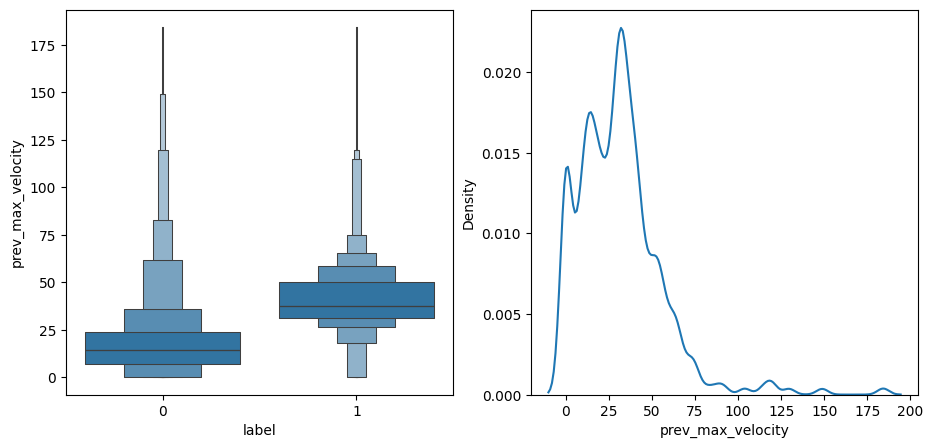

In [79]:
import seaborn as sns
df_meanVis = trn_df[(trn_df.next_mean_velocity>0)]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_meanVis, x=dep, y="prev_max_velocity", ax=axs[0])
sns.kdeplot(data=df_meanVis, x="prev_max_velocity", ax=axs[1]); 

In [128]:
def xs_y(df):
    xs = df[conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import joblib


In [129]:

rf_phy = RandomForestClassifier(300, min_samples_leaf=30)
rf_phy.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf_phy.predict(val_xs))

0.0325782092772384

In [130]:
from sklearn.metrics import accuracy_score
print(accuracy_score(val_y, rf_phy.predict(val_xs)))

0.9674217907227616


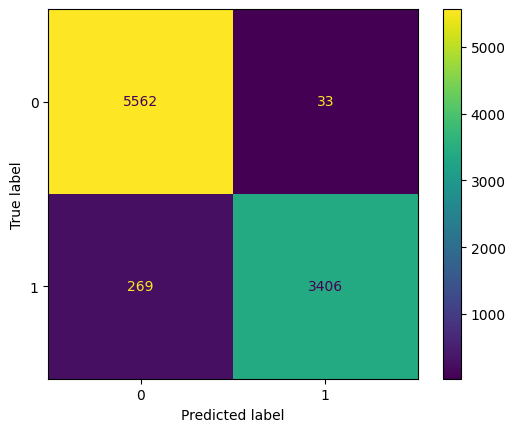

In [131]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf_phy, val_xs, val_y)

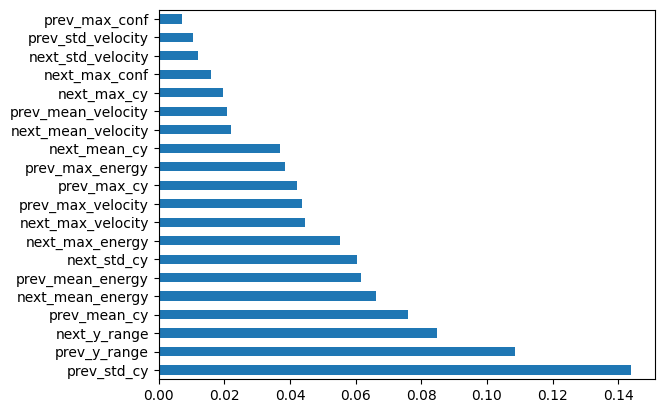

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a series with feature names and their importance scores
feat_importances = pd.Series(rf_phy.feature_importances_, index=trn_xs.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [647]:
import joblib

# Save the model
joblib.dump(rf_phy, 'my_random_forest_phy_2.pkl')

['my_random_forest_phy_2.pkl']

In [ ]:
loaded_rf = joblib.load('my_random_forest_phy_1.pkl')

In [5]:
def train_random_forest(df_path,labels_path,window_size=120,interpolation_size=10,num_est=100,num_min_samples=20):
    df = pd.read_csv(df_path)
    labels = pd.read_csv(labels_path)
    clean_df= clean_noise(df)
    features_df = extract_features(clean_df, window_size=window_size,interpolation_size=interpolation_size)
    features_df['label'] = labels['label']
    features_df = features_df.fillna(0)

    conts = ['mean_x', 'mean_y', 'std_x', 'std_y', 'mean_velocity', 'max_velocity', 'std_velocity',
             'mean_acceleration', 'mean_angle_change', 'mean_y_dominance', 'mean_accel_jitter', 'mean_energy', 'y_range_window', 'mean_vis', 'vis_std', 'is_low_window']
    dep="label"

    trn_df, val_df = train_test_split(features_df, test_size=0.25,shuffle=False)
    trn_df = trn_df.copy()
    val_df = val_df.copy()

    trn_df[dep] = pd.Categorical(trn_df[dep]).codes
    val_df[dep] = pd.Categorical(val_df[dep]).codes
    
    def xs_y(df):
        xs = df[conts].copy()
        return xs,df[dep] if dep in df else None

    trn_xs,trn_y = xs_y(trn_df)
    val_xs,val_y = xs_y(val_df)

    rf_phy = RandomForestClassifier(num_est, min_samples_leaf=num_min_samples)
    rf_phy.fit(trn_xs, trn_y);
    print("Validation MAE:", mean_absolute_error(val_y, rf_phy.predict(val_xs)))
    print("Validation Accuracy:", accuracy_score(val_y, rf_phy.predict(val_xs)))
    return rf_phy

    

In [9]:
data_path = "C:\\Users\\morde\\Desktop\\projects\\test vb cv\\my_code\\ball_detector\\game1_set1_physics_tracking.csv"
labels_path = "C:\\Users\\morde\\Desktop\\projects\\test vb cv\\my_code\\ball_detector\\labels.csv"
rf = train_random_forest(data_path, labels_path, window_size=120, interpolation_size=5)

Cleanup complete. Remaining tracks: 159
Validation MAE: 0.07378640776699029
Validation Accuracy: 0.9262135922330097


In [21]:
data_path = "C:\\Users\\morde\\Desktop\\projects\\test vb cv\\my_code\\ball_detector\\game1_set1_physics_tracking.csv"
labels_path = "C:\\Users\\morde\\Desktop\\projects\\test vb cv\\my_code\\ball_detector\\labels.csv"
rf = train_random_forest(data_path, labels_path, window_size=60, interpolation_size=5)

Cleanup complete. Remaining tracks: 159
Validation MAE: 0.04735706580366775
Validation Accuracy: 0.9526429341963323


In [10]:
# Save the model
joblib.dump(rf, 'rally_predictor_rf_2.pkl')

['rally_predictor_rf_2.pkl']

In [603]:
def predict_rallies(rf_model, df_path, window_size=120, interpolation_size=10):
    df = pd.read_csv(df_path)
    clean_df= clean_noise(df)
    features_df = extract_features(clean_df, window_size=window_size,interpolation_size=interpolation_size)
    features_df = features_df.fillna(0)
    conts = ['mean_x', 'mean_y', 'std_x', 'std_y', 'mean_velocity', 'max_velocity', 'std_velocity',
             'mean_acceleration', 'mean_angle_change', 'mean_y_dominance', 'mean_accel_jitter', 'mean_energy', 'y_range_window', 'mean_vis', 'vis_std', 'is_low_window']
    predictions = rf_model.predict(features_df[conts])
    return predictions

In [736]:
data_path = '../ball-detector/game7_full_physics_tracking.csv'
predictions = predict_rallies(rf, data_path, window_size=90, interpolation_size=30)

Cleanup complete. Remaining tracks: 530


In [683]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [605]:
import pandas as pd
import numpy as np

def analyze_rally_stats(predictions, fps=30):
    # Convert to Series for easier manipulation
    s = pd.Series(predictions)
    
    # Identify groups of consecutive identical values
    # (e.g., [0,0,1,1,1,0] becomes [1,1,2,2,2,3])
    groups = (s != s.shift()).cumsum()
    
    # Create a DataFrame of segments
    segments = s.groupby(groups).agg(
        label='first',
        frame_count='count'
    )
    
    # Calculate duration in seconds
    segments['duration_sec'] = segments['frame_count'] / fps
    
    # Filter for Rallies and Downtime
    rallies = segments[segments['label'] == 1]['duration_sec']
    downtime = segments[segments['label'] == 0]['duration_sec']
    
    stats = {
        "Total Rallies": len(rallies),
        "Shortest Rally (s)": rallies.min() if not rallies.empty else 0,
        "Longest Rally (s)": rallies.max() if not rallies.empty else 0,
        "Average Rally (s)": rallies.mean() if not rallies.empty else 0,
        "Shortest Downtime (s)": downtime.min() if not downtime.empty else 0,
        "Total Playtime (s)": rallies.sum()
    }
    
    return stats, segments

In [737]:
stats, segments = analyze_rally_stats(predictions=predictions, fps=30)

In [738]:
stats

{'Total Rallies': 451,
 'Shortest Rally (s)': 0.03333333333333333,
 'Longest Rally (s)': 39.46666666666667,
 'Average Rally (s)': 3.3099778270509983,
 'Shortest Downtime (s)': 0.03333333333333333,
 'Total Playtime (s)': 1492.8000000000002}

In [686]:
segments[0:30] 

,label,frame_count,duration_sec
1,0,6429,214.300000
2,1,162,5.400000
3,0,692,23.066667
4,1,104,3.466667
5,0,36,1.200000
6,1,3,0.100000
7,0,1,0.033333
8,1,544,18.133333
9,0,51,1.700000
10,1,1,0.033333


In [687]:
def smooth_predictions(predictions, window_size=5, min_segment_len=60):
    if len(predictions) == 0:
        return predictions

    # 1. Apply rolling mode filter
    # center=True ensures the window is balanced around the current frame
    series = pd.Series(predictions)
    smoothed = series.rolling(window=window_size, center=True).apply(
        lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[len(x)//2]
    ).fillna(series) # Fill NaNs at edges with original values
    
    smoothed_list = smoothed.tolist()

    # 2. Merge small segments
    # We loop until no more small segments are found to handle 
    # cases where merging creates a new small segment
    changed = True
    while changed:
        changed = False
        i = 0
        while i < len(smoothed_list):
            start = i
            val = smoothed_list[i]
            
            # Find the end of the current segment
            while i < len(smoothed_list) and smoothed_list[i] == val:
                i += 1
            segment_len = i - start
            
            # If segment is too short, merge it
            if segment_len < min_segment_len:
                # Determine the replacement value
                # Prefer the neighbor that exists; if both exist, 
                # you could pick the longer one or just the previous one.
                prev_val = smoothed_list[start - 1] if start > 0 else None
                next_val = smoothed_list[i] if i < len(smoothed_list) else None
                
                new_val = prev_val if prev_val is not None else next_val
                
                if new_val is not None and new_val != val:
                    smoothed_list[start:i] = [new_val] * segment_len
                    changed = True
                    
    return smoothed_list


In [739]:
s_predictions = smooth_predictions(predictions, window_size=5, min_segment_len=60)

In [741]:
stats, segments = analyze_rally_stats(predictions=s_predictions, fps=30)

In [742]:
stats

{'Total Rallies': 129,
 'Shortest Rally (s)': 2.1666666666666665,
 'Longest Rally (s)': 48.833333333333336,
 'Average Rally (s)': 11.627906976744185,
 'Shortest Downtime (s)': 2.2,
 'Total Playtime (s)': 1500.0}

In [644]:
segments[0:20]

,label,frame_count,duration_sec
1,1.0,231,7.700000
2,0.0,475,15.833333
3,1.0,277,9.233333
4,0.0,466,15.533333
5,1.0,490,16.333333
6,0.0,470,15.666667
7,1.0,450,15.000000
8,0.0,411,13.700000
9,1.0,256,8.533333
10,0.0,435,14.500000


In [743]:
pd.DataFrame({'s_predictions': s_predictions}).to_csv('s_predictions_game7_full.csv', index=False)